# Markov Chain Monte Carlo (MCMC)

Мотивирующий пример: кандидат в губернаторы объезжает города свого края с целью агитации. Каждый день для выбора следующего города он случайным образом намечает один из городов, соседних к текущему. Если число жителей в намеченном городе больше, чем в текущем, кандидат перемещается в намеченный город. В противном случае кандидат перемещается в намеченный город с вероятностью, равной отношению числа жителей этого города к числу жителей текущего, либо остается в текущем еще на один день. Проведя достаточно долгую агитационную кампанию выясняется, что доля времени, проведенная в каждом городе, пропорциональна числу жителей этого города. Убедимся в этом:

Задаем популяцию 15 городов случайными числами от 10 до 100:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

cities = np.random.randint(10, 100, 15)

plt.bar(np.arange(len(cities)), cities)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

<Figure size 640x480 with 1 Axes>

Задаем функцию, которая определяет номер следующего города, куда отправляется кандитат (возможно, остается в текущем городе):

In [2]:
def step(current, cities):
    direction = np.random.choice([-1, 1])
    target = (current + direction) % len(cities)
    ratio = cities[target] / cities[current]
    return target if np.random.rand() < ratio else current

Моделируем перемещения кандитата за период 10000 дней:

In [3]:
walk = []
current = 1
for i in range(10000):
    current = step(current, cities)
    walk.append(current)

Рисуем гистограмму распределения доли времени, проведенного в каждом городе:

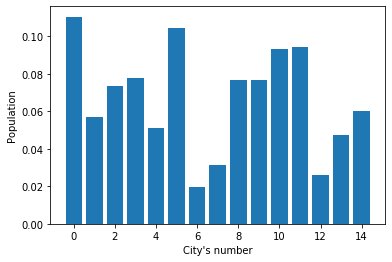

In [4]:
plt.hist(walk, bins=np.arange(len(cities) + 1) - 0.5, rwidth=0.8, density=True)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

Вывод: мы смогли достаточно точно оценить распределение числа жителей по городам, а выборка в массиве ```walk``` может быть использована как выборка из этого распределения!

Общая идея MCMC:
* построить эргодическую цепь Маркова, для которой стационарное распределение - это в точности наше заданное распределение

* инициировать блуждание по цепи Маркова из некоторого начального состояния и дождаться, когда распределение сойдется в стационарному. С этого момента состояния цепи Маркова можно считать выборкой из желаемого распределения.

Алгоритм Metropolis sampling:
* пусть $\pi$ - заданное распределение (не обязательно нормированное к 1) на множестве $\Omega$
* пусть $Q = (q_{i, j})$ - матрица переходных вероятностей произвольной эргодической цепи Маркова с состояниями из $\Omega$
* выберем произвольное $X_0$ из $\Omega$
* для текущего $X_n$ смоделируем значение $Z_{n+1}$ из распределения $q_{X_n, \cdot}$
* смоделируем случайную величину $\alpha$ из распределения Бернулли с вероятностью успеха
$$
p = \min ( 1, \frac{\pi_i q_{i, j}}{\pi_j q_{j, i}} )
$$
* если $\alpha$ = 1, то $X_{n+1} = Z_{n+1}$, иначе $X_{n+1} = X_{n}$.

In [5]:
def metroplis(start, value, proposal, niter, nburn=0, **kwargs):
    '''Generic Metropolis scheme.
    Parameters
    ---
    start : misc
        Initial guess.
    value : callable
        Function to calculate density (unnormalized) at given point.
    proposal : callable
        Function to get suggestion on a new point based on a current one.
    niter : int
        Number of iterations.
    nburn : int
        Number of initial samples to be skipped.
    kwargs : dict
        Keywords to be passed in value and proposal.

    Return
    ---
    post : list
        List of samples obtained.
    '''
    current = start
    post = [current]
    for i in range(niter):
        proposed = proposal(current, **kwargs)
        p = value(proposed, **kwargs) / value(current, **kwargs)
        if np.random.rand() < p:
            current = proposed
        post.append(current)
    return post[nburn:]

Прложение к предыдущей задаче:

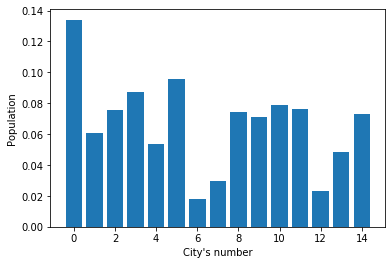

In [6]:
value = lambda x: cities[x]
proposal = lambda x: (x + np.random.choice([-1, 1])) % len(cities)
post = metroplis(1, value, proposal, 10000)

plt.hist(post, bins=np.arange(len(cities) + 1) - 0.5, rwidth=0.8, density=True)
plt.xlabel('City\'s number')
plt.ylabel('Population')
plt.show()

## MCMC  в задаче байесовской оценки параметров

Оценка параметров при данном наблюдении X выводится из известной формулы

$p(\theta \ | \ X) = \frac{p(X \ | \ \theta) p(\theta)}{\int p(X \ | \ \theta) p(\theta) \rm d\theta}$

Здесь
* $p(\theta)$ - prior
* $p(X \ | \ \theta)$ - likelihood
* $p(\theta \ | \ X)$ - posterior
* $p(X) = \int p(X \ | \ \theta) p(\theta) \rm d\theta$ - evidence or marginal likelihood

Разберем простейший пример, в котором оценка выводится аналитически, и сопоставим ее с численным расчетом.

Как всегда, подбрасываем монету, $\theta$ - неизвестный параметр успеха (выроятность выпадения орла). В качесте 
априорного распределения выберем бета-распределение $Beta(a, b)$. Напомним формулу для плотности вероятности $Beta(a, b)$:

$p(\theta) = \frac{1}{B(a, b)}\theta^{a-1}(1-\theta)^{b-1}$.

Функция правдоподобия в нашем случае:

$p(X \ | \ \theta) = C_N^X\theta^X(1-\theta)^{N-X}$.

Нетрудно убедиться, что $p(\theta \ | \ X) = Beta(X+a, N-X+b)$.

Построим графики априорного, апостериорного распределения и оценку $\theta$ по методу максимума апестериорного распредленеия (MAP) в предположении, что эксперимент с подбрасывание монеты N=100 раз завершился Х=61 успехом. Для сравнения нарисуем график правдоподобия и соответствующую оценку максимального правдоподобия (MLE): 

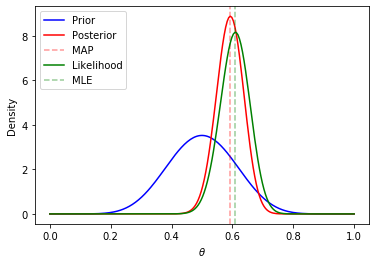

In [7]:
from scipy import stats

a, b = 10, 10

N = 100
X = 61

prior = stats.beta(a, b)
post = stats.beta(X+a, N-X+b)
likelihood = lambda thetas: stats.binom(N, thetas).pmf(X)

thetas = np.linspace(0, 1, 200)
plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, post.pdf(thetas), label='Posterior', c='red')
plt.axvline((X + a - 1)/(N + a + b - 2), c='red', linestyle='dashed', alpha=0.4, label='MAP')
plt.plot(thetas, N*likelihood(thetas), label='Likelihood', c='green')
plt.axvline(X/N, c='green', linestyle='dashed', alpha=0.4, label='MLE')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.legend(loc='upper left')
plt.show()

Размерность пространства параметров небольшая, поэтому в качестве численного эксперимента получим оценку апостериорного распределения, явно перебрав возможные значения $\theta$ и вычислив нормировочный интеграл:

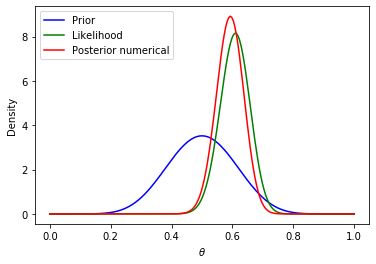

In [8]:
thetas = np.linspace(0, 1, 200)

post = prior.pdf(thetas) * stats.binom(N, thetas).pmf(X)
post /= (post.sum() / len(thetas))

plt.plot(thetas, prior.pdf(thetas), label='Prior', c='blue')
plt.plot(thetas, N*likelihood(thetas), label='Likelihood', c='green')
plt.plot(thetas, post, label='Posterior numerical', c='red')
plt.xlabel(r'$\theta$')
plt.ylabel('Density')
plt.legend()
plt.show()

У нас все получилось, поскольку перебрать возможные значения $\theta$ и вычислить интеграл в знаменателе оказалось легкой задачей. В пространстве параметров большей размерности перебор станет проблемой. На помощь приходит МСМС.

## Metropolis sampler

In [9]:
def value(theta, **kwargs):
    _ = kwargs
    if theta < 0 or theta > 1:
        return 0
    else:
        return likelihood(theta) * prior.pdf(theta)

In [10]:
def proposal(current, sigma, **kwargs):
    _ = kwargs
    current = np.asarray(current)
    sigma = np.asarray(sigma)
    return current + sigma * np.random.randn(*current.shape)

In [11]:
sigma = 0.3

post = metroplis(0.2, value, proposal, 3000, sigma=0.1)

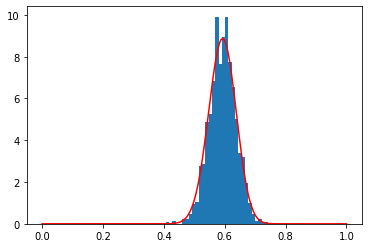

In [12]:
plt.hist(post, bins=50, density=True, label='MCMC posterior')
plt.plot(thetas, stats.beta(X+a, N-X+b).pdf(np.linspace(0, 1, 200)),
         label='True posterior', c='red')
plt.show()

Траектория блуждания:

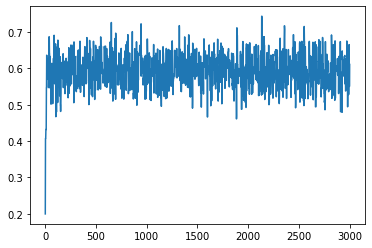

In [13]:
plt.plot(post)
plt.show()

### Выбор ширины шага

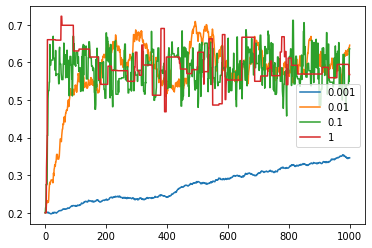

In [14]:
for sigma in [0.001, 0.01, 0.1, 1]:
    post = metroplis(0.2, value, proposal, 1000, sigma=sigma)
    plt.plot(post, label=sigma)
plt.legend()
plt.show()

Вывод: шаг sigma=0.1 (зеленая траектория) оказался удачным выбором.


### Выбор начального приближения

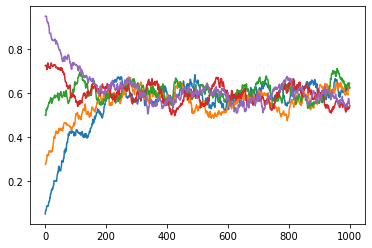

In [15]:
for start in np.linspace(0.05, 0.95, 5):
    post = metroplis(start, value, proposal, 1000, sigma=0.01)
    plt.plot(post)
plt.show()

Вывод: нужно отбрасывать первые nbirn элементов выборки.

### Анализ корреляций

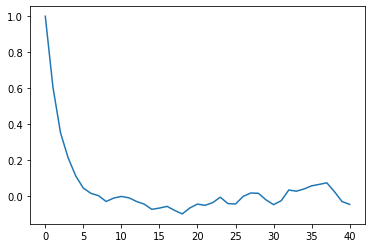

In [16]:
from statsmodels.tsa import stattools

post = metroplis(0.2, value, proposal, 1000, sigma=0.1)

autocorr = stattools.acf(post[100:], fft=False)

plt.plot(autocorr)
plt.show()

Вывод: есть смысл прореживать выборку и брать элементы с шагом, например, 5.

### Проверка стационарности

Gewerke test:

Разбиваем выборку на начальный и конечный куски $x_s$, $x_e$ и вычисляем статистику t-критерия Стьюдента.

In [17]:
def g_test(x, start=0.1, end=0.5):
    return stats.ttest_ind(x[:int(len(x) * start)], x[-int(len(x) * end):], equal_var=False)

Проверим для sigma=0.1:

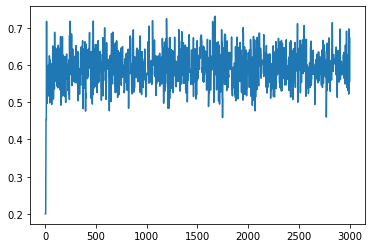

Ttest_indResult(statistic=-0.35270486836524434, pvalue=0.7244940782373612)

In [18]:
post = metroplis(0.2, value, proposal, 3000, sigma=0.1)
plt.plot(post)
plt.show()

g_test(post[100:])

Вывод: гипотезу стацинарности не отвергаем.

Проверим для sigma=0.01:

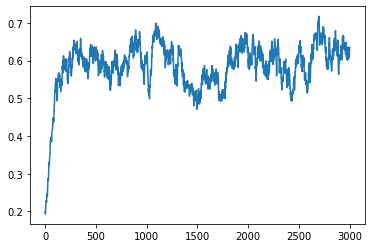

Ttest_indResult(statistic=-12.728678005781292, pvalue=2.889450678800417e-30)

In [19]:
post = metroplis(0.2, value, proposal, 3000, sigma=0.01)
plt.plot(post)
plt.show()

g_test(post)

In [20]:
g_test(post[1000:])

Ttest_indResult(statistic=5.900873560015382, pvalue=1.132783270543687e-08)

Вывод: стационарность не подтверждается.


## Gibbs sampler

Для оценки набора парамеров $\theta = (\theta_1, \theta_2, ..., \theta_m)$ используем схему:

$\theta_i^{(t)} \sim p(\theta_i^{(t)}\ | \ \theta_1=\theta_1^{t}, ..., \theta_{i-1}=\theta_{i-1}^{t},
\theta_{i+1}=\theta_{i+1}^{t-1}, \theta_{m}=\theta_{m}^{t-1})$.

Пример: подбрасываем две монеты с параметрами $\theta_1$, $\theta_2$ и наблюдаем за числом успехов.

Зададим правдоподобия для одной монеты и для пары:

In [21]:
def bern(theta, z, N):
    """Bernoulli likelihood with N trials and z successes for a single coin."""
    return theta**z * (1 - theta)**(N - z)

def bern2(theta1, theta2, z1, z2, N1, N2):
    """Bernoulli likelihood with N trials and z successes for two coins."""
    return bern(theta1, z1, N1) * bern(theta2, z2, N2)

Вспомогательные методы для рисования графиков:

In [22]:
def make_plots(X, Y, prior, likelihood, posterior):
    fig, ax = plt.subplots(1, 3, figsize=(12, 3))
    ax[0].contour(X, Y, prior, cmap=plt.cm.jet)
    ax[1].contour(X, Y, likelihood, cmap=plt.cm.jet)
    ax[2].contour(X, Y, posterior, cmap=plt.cm.jet)
    ax[0].set_title('Prior')
    ax[1].set_title('Likelihood')
    ax[2].set_title('Posteior')
    plt.show()

thetas1 = np.linspace(0.05, 0.95, 100)
thetas2 = np.linspace(0.05, 0.95, 100)
X, Y = np.meshgrid(thetas1, thetas2)

Аналитические графики априорного распределение, правдоподобия и апостериорного распределения:

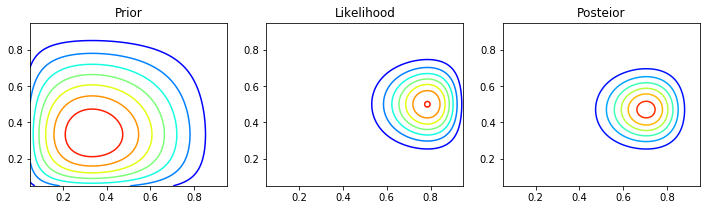

In [23]:
a = 2
b = 3

z1 = 11
N1 = 14
z2 = 7
N2 = 14

prior = lambda theta1, theta2: stats.beta(a, b).pdf(theta1) * stats.beta(a, b).pdf(theta2)
likelihood = lambda theta1, theta2: bern2(theta1, theta2, z1=z1, z2=z2, N1=N1, N2=N2)
posterior = stats.beta(a + z1, b + N1 - z1).pdf(X) * stats.beta(a + z2, b + N2 - z2).pdf(Y)

make_plots(X, Y, prior(X, Y), likelihood(X, Y), posterior)

Metropolis scheme:

In [24]:
def value(theta, **kwargs):
    _ = kwargs
    theta1, theta2 = theta
    if theta1 < 0 or theta1 > 1:
        return 0
    if theta2 < 0 or theta2 > 1:
        return 0
    return likelihood(theta1, theta2) * prior(theta1, theta2)


def proposal(current, sigma, **kwargs):
    _ = kwargs
    current = np.asarray(current)
    sigma = np.asarray(sigma)
    return current + sigma * np.random.randn(*current.shape)

theta = np.array([0.2, 0.1])
niters = 5000
nburn = 200
sigma = np.diag([0.2, 0.2])

post = metroplis(theta, value, proposal, niter=niters,
                 nburn=0, sigma=np.array([0.1, 0.1]))

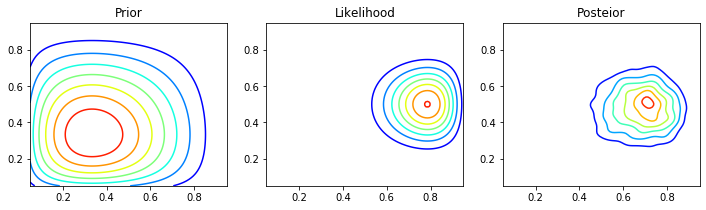

In [25]:
kde = stats.gaussian_kde(np.array(post[nburn:]).T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_metroplis = kde(XY).reshape(X.shape)

make_plots(X, Y, prior(X, Y), likelihood(X, Y), posterior_metroplis)

Траектория блуждания на начальном этапе:


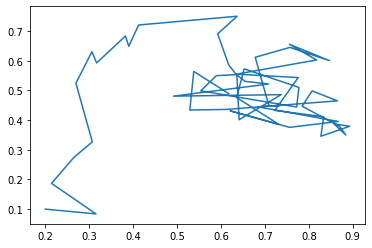

In [26]:
plt.plot(*np.array(post[:100]).T)
plt.show()

Gibbs scheme:

In [27]:
theta = np.array([0.2, 0.1])

post = [theta]
for i in range(niters):
    theta = [stats.beta(a + z1, b + N1 - z1).rvs(), theta[1]]
    theta = [theta[0], stats.beta(a + z2, b + N2 - z2).rvs()]
    post.append(theta)

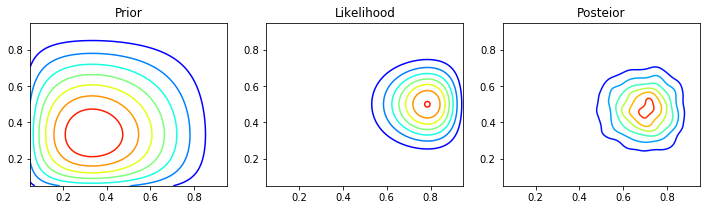

In [28]:
kde = stats.gaussian_kde(np.array(post[nburn:]).T)
XY = np.vstack([X.ravel(), Y.ravel()])
posterior_gibbs = kde(XY).reshape(X.shape)

make_plots(X, Y, prior(X, Y), likelihood(X, Y), posterior_gibbs)

Траектория блуждания на начальном этапе:

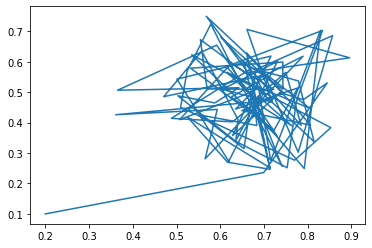

In [29]:
plt.plot(*np.array(post[:100]).T)
plt.show()

Done!

## Домашнее задание

Рассмотрим граф $G=(V,E)$, вершинам которого случайным образом приписаны значения 0 и 1 так, что смежные вершины не могут одновременно иметь значение 1. Пример расстановки значений по вершинам графа показан на картинке ниже (черные вершины имеют значение 1, белые - 0):

![img](http://www.mathematik.uni-ulm.de/stochastik/lehre/ss06/markov/skript_engl/bild4.jpg)

Как оценить, сколько в среднем закрашенных вершин будет иметь такой граф?

Сформулируем задачу в математических терминах.

Пусть $\xi \in \{0,1\}^{V}$ обозначает конфигурацию графа (расстановку 0 и 1 по вершинам). Назовем конфигурацию допустимой, если вершины, соединенные ребрами, не имеют одновременно значения 1. Пусть $Z_G$ - общее количество допустимых конфигураций. Зададим  распределение на множестве всех конфигураций:
$$\begin{equation*}
\mu(\xi) = 
 \begin{cases}
   \frac{1}{Z_G}, &\text{$\xi$ - допустимая конфигурация}\\
   0, &\text{иначе.}
 \end{cases}
\end{equation*}$$
Обозначим $n(\xi)$ - число закрашенных вершин в конфигурации $\xi$. Тогда
$$
{\rm E} n(\xi) = \sum\limits_{x \in \{0,1\}^V} n(x) \mu(x) = \frac{1}{Z_G} \sum\limits_{x \in \{0,1\}^V} n(x) {\rm I}_{\{x - \text{допустимая} \}}
$$

Явно перебирать все $x \in \{0,1\}^{V}$ не представляется возможным. Мы могли бы попробовать оценить ${\rm E} n(\xi)$, используя закон больших чилел:
$$
{\rm E} n(\xi) \approx \frac{1}{N} \sum\limits_{i=1}^{N} n(\xi), \text{где $\xi \sim \mu$}
$$
Но есть проблема: как смоделировать случайную величину из распределения $\mu$?

В этом нам поможет метод MCMC.

## Задание

* Оценить  ${\rm E} n(\xi)$ с помощью МСМС для графа 8х8
* Обосновать численно и графически стационарность
* Построить график распределеиня $n(\xi)$

Вспомогательная функция для раскраски вершин графа в соответствии с переданной маской:

In [0]:
import matplotlib.pyplot as plt
import numpy as np

def plot_grid(narr):
    '''Plots 2d lattice with vertices colored in black and red according to given mask.
    Vertice is colored black if narr[i, j] == True and red otherwise.
    
    Parameters
    ----------
    narr : 2d boolean ndarray
        Mask for vertices colors
    '''

    if narr.dtype != 'bool':
        raise ValueError('narr should be a boolean ndarray')
    colors = np.empty(narr.shape, dtype='U5')
    colors[:] = 'red'
    colors[narr] = 'black'
    x, y = np.indices((narr.shape))
    plt.scatter(x, y, c=colors.ravel())
    plt.show()

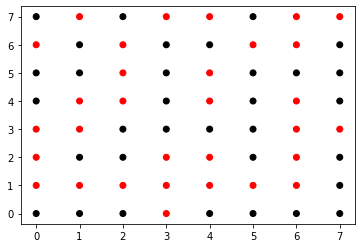

In [0]:
size = 8
narr = np.random.choice([0, 1], size=size**2).reshape((size, size)).astype('bool')

plot_grid(narr)

## Литература

*  http://probability.ca/jeff/ftpdir/johannes.pdf
* http://nitro.biosci.arizona.edu/courses/EEB596/handouts/Gibbs.pdf


# Idea

1. Markov Chain

Я буду брать нулевую матрицу булей за стартовую а потом семплить с помощью поlсчета всех возможных позиций для единицы. Подсчитал, поменял в рандомном месте из пред пункта значение на противоположное. Если стало больше, то это следующий шаг, если нет, то с вероятностью M/N следующий шаг, где M - кол-во позиций для единицы в переставленном, N - в текущем. 
2. Monte-Carlo

Засемплю таких много, подсчитаю единицы в каждом и усредню.

# Implemention

In [30]:
def test(chain, current, size):
    for i in range(size):
        for j in range(size):
            if current[i, j] or ((i == 0 or not current[i - 1, j]) and (j == 0 or not current[i, j - 1]) and (i == size - 1 or not current[i + 1, j]) and  (j == size - 1 or not current[i, j + 1])):
                chain.append((i, j))
def MC (current, size):
    chain = []
    test(chain, current, size)
    ran = chain[np.random.randint(0, len(chain))]
    
    new = np.array(current)
    new[ran[0], ran[1]] = not current[ran[0], ran[1]]
 
    new_chain = []
    test(new_chain, current, size)
 
    if np.random.uniform() > len(chain)/len(new_chain):
        return current
    return new

In [33]:
size = 8
current = np.zeros(size*size).reshape(size,size)
chains = []
for i in range(50000):
    current = MC(current, size)
    chains.append((abs(current)).sum())
np.array(chains).mean()

15.18044

# Tests

In [40]:
from scipy import stats
def g_test(x, start=0.1, end=0.5):
    return stats.ttest_ind(x[:int(len(x) * start)], x[-int(len(x) * end):], equal_var=False)


for i in range(5):  
    print(g_test(chains[1000*i:]))

Ttest_indResult(statistic=-1.1208013451841452, pvalue=0.2624112574056229)
Ttest_indResult(statistic=-1.4900893101862027, pvalue=0.13624582244899705)
Ttest_indResult(statistic=2.8330605385723615, pvalue=0.004623882289960231)
Ttest_indResult(statistic=1.1560559924728655, pvalue=0.24769871799220533)
Ttest_indResult(statistic=3.300582442674225, pvalue=0.0009698756031992046)


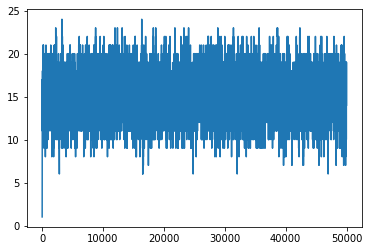

In [42]:
plt.plot(chains)
plt.show()

Судя по p-value и графическому анализу можно заключить, что стационарность есть.

# Distribution

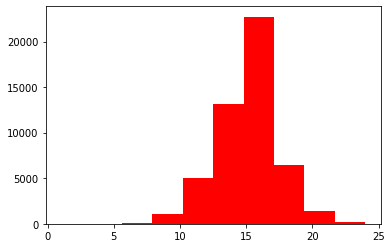

In [46]:
plt.hist(chains, color = 'red')
plt.show()